# RAG w/ Langgraph
랭그래프에 RAG 추가하기

In [3]:
from dotenv import load_dotenv

load_dotenv()

True

In [ ]:
# RAG 준비

# 1. Loader
from langchain_community.document_loaders import WebBaseLoader
from bs4.filter import SoupStrainer

loader = WebBaseLoader(
    web_paths=('https://lilianweng.github.io/posts/2023-06-23-agent/',),  # 여러개 가져오려면 튜플 안에 추가하면 됨
    # 웹페이지에서 필요한 정보를 선택하기
    bs_kwargs={
        'parse_only': SoupStrainer(class_=['post-content'])
    },
    # header_template={},
)
docs = loader.load()

# 웹페이지를 그대로 긁어오면, 필요없는 부분(사이트 제목, 밑에 광고들, 등등)이 뒤섞여서 나온다. -> 필요한 부분을 선택적으로 가져와야 함 -> bs_kwargs
# from pprint import pprint
# pprint(docs[0].page_content)

# 2. Splitter
from langchain_text_splitters import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=500
)
splitted_docs = splitter.split_documents(docs)
# print(len(splitted_docs))

# 3. Enbedding Model
from langchain_openai import OpenAIEmbeddings

embedding = OpenAIEmbeddings(model='text-embedding-3-small')  # small <-> large

# 4. Vectorstore (일단은 FAISS, 나중엔 클라우드(Pinecone)에 저장할 것)
from langchain_community.vectorstores import FAISS

vectorstore = FAISS.from_documents(splitted_docs, embedding=embedding)

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
# 프롬프트
from langchain import hub

prompt = hub.pull('rlm/rag-prompt')
for msg in prompt.messages:
    msg.pretty_print()

================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


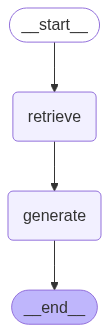

In [4]:
# 랭그래프

# 1. State
from typing_extensions import TypedDict, List
from langchain_core.documents import Document

class State(TypedDict):
    # 프롬프트에 뚫린 구멍은 반드시 채워줘야함
    question: str  # 사용자의 질문
    context: List[Document]  # LLM에게 전달할 RAG 데이터의 문서조각. List[Document]는 context에 Document 객체가 리스트로 모여있을 것이라는 의미
    answer: str  # LLM의 답안

# 2. Node
# 2-1. 검색노드
def retrieve(state: State):
    retrieved_docs = vectorstore.similarity_search(state['question'], k=4)  # [Document 타입 객체 x 4]
    return {'context': retrieved_docs}  # 언급하지 않은 state 항목들(question, answer)은 내부적으로 알아서 그대로 들어가짐

# 2-2. 답변생성노드
from langchain_openai import ChatOpenAI

def generate(state: State):

    # 내용에 해당하는 page_content만 모아서 토큰 절약
    context_str = ''
    for doc in state['context']:
        context_str += doc.page_content + '\n-----------------------------------------------\n'

    question_with_context = prompt.invoke({'question': state['question'], 'context': context_str})
    llm = ChatOpenAI(model='gpt-4.1', temperature=0)
    res = llm.invoke(question_with_context)    
    return {'answer': res.content}

# 3. Graph
from langgraph.graph import START, END, StateGraph

builder = StateGraph(State)

builder.add_node('retrieve', retrieve)
builder.add_node('generate', generate)

builder.add_edge(START, 'retrieve')
builder.add_edge('retrieve', 'generate')
builder.add_edge('generate', END)

graph = builder.compile()

# 4. 시각화
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
final_state = graph.invoke({'question': '에이전트 시스템에 대해 알려줘'}) 

print(final_state['answer'])

에이전트 시스템은 주어진 목표를 달성하기 위해 자율적으로 작업을 수행하는 소프트웨어 구조입니다. LLM(대형 언어 모델) 기반 에이전트 시스템은 인터넷 검색, 장기 기억 관리, 파일 출력, 외부 API 호출 등 다양한 도구를 활용해 복잡한 문제를 해결할 수 있습니다. 또한, 자신의 행동을 지속적으로 평가하고 효율적으로 작업을 수행하도록 설계되어 있습니다.


## RAG +a

### 메타데이터 편집
원본 내용은 그대로 두되, 추가적으로 넣고 싶은 내용을 추가/삭제할 수 있다

In [6]:
# splitted_docs를 나눠서 전/중/후반부를 메타데이터에 추가하고 싶음
third = len(splitted_docs) // 3

for idx, doc in enumerate(splitted_docs):
    if idx < third:
        doc.metadata['section'] = 'beginning'
    elif idx < third * 2:
        doc.metadata['section'] = 'middle'        
    else:
        doc.metadata['section'] = 'end'
print(splitted_docs[0].metadata)

vectorstore = FAISS.from_documents(splitted_docs, embedding=embedding) 

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'section': 'beginning'}


### 쿼리 분석/개선

질문이 이어질 때, 이전 질문 내용을 사용해야 하는 질문이 들어오는 경우가 있다.

지금 질문 + 이전 질문 내용과 답변 내용을 LLM에 넣어서, 새로 적합한 쿼리를 만들어서 RAG를 돌려줘야 함

In [7]:
# 쿼리를 분석해서, 질문에 전/중/후반부가 있다면 메타데이터를 참고하면 좋겠음
from typing import Literal  # 말 그대로
from typing_extensions import Annotated  # 첨언, 주석


# StructuredOutput에서 사용하기 좋다. pydantic이랑 비슷한거
class Search(TypedDict):
    '''Vectorstore Search Query'''
    # Annotated[타입(str), NOT NULL(... : 비어있지 않다), 설명(이 항목에 대한 설명)]
    query: Annotated[str, ..., 'search query to run']
    section: Annotated[
        Literal['beginning', 'middle', 'end'],  # section은 전/중/후반부만 존재함
        ...,
        'Section to query'
    ]
    
# question / query: question보다 좀 더 유사도 검색이 잘 되게 하는 query가 필요함
class MyState(TypedDict):
    question: str  
    query: Search  # 이 쿼리는 Search를 참고할 것 -> state를 더 자세하게 정의하기 위해 따로 정의한 class Search
    context: List[Document]
    answer: str

In [12]:
llm = ChatOpenAI(model='gpt-4.1', temperature=0)

s_llm = llm.with_structured_output(Search)  # 답변이 무조건 Search 클래스의 인스턴스로 나온다
s_llm.invoke('그그 문서 앞쪽에 LLM 작ㅇ업 분해인가 하는 그게 뭐야')  # 벡터스토어에 비교하기 훨씬 좋게 맞춰준다. 기준은 Search 클래스의 docstring에 써있는 그대로.

{'query': 'LLM 작업 분해', 'section': 'beginning'}

In [13]:
def analyze_query(state: MyState):
    # Search 클래스에 맞게 사용자의 question을 {query, section}으로 바꿔줌
    s_llm = llm.with_structured_output(Search)  # 답변이 무조건 Search 클래스의 인스턴스로 나온다
    query = s_llm.invoke(state['question'])
    return {'query': query}

def retrieve(state: MyState):
    query = state['query']
    retrieved_docs = vectorstore.similarity_search(
        query['query'], 
        # 필터함수를 돌려서 section이 쿼리의 section과 맞을 경우만 추려냄
        filter=lambda metadata: metadata.get('section') == query['section']  # 벡터스토어의 결과에도 검증함수를 걸 수 있고, 그냥 데이터만이 아니라 메타데이터도 조건에 걸 수 있다. 
    )
    return {'context': retrieved_docs}  # 언급하지 않은 state 항목들(question, answer)은 내부적으로 알아서 그대로 들어가짐

def generate(state: MyState):
    context_str = ''
    for doc in state['context']:
        context_str += doc.page_content + '\n-----------------------------------------------\n'

    question_with_context = prompt.invoke({'question': state['question'], 'context': context_str})
    res = llm.invoke(question_with_context)    
    return {'answer': res.content}

builder = StateGraph(State)

builder.add_node('analyze_query', analyze_query)
builder.add_node('retrieve', retrieve)
builder.add_node('generate', generate)

builder.add_edge(START, 'analyze_query')
builder.add_edge('analyze_query', 'retrieve')
builder.add_edge('retrieve', 'generate')
builder.add_edge('generate', END)

graph = builder.compile()

In [ ]:
graph.invoke({'question': '그그 문서 앞쪽에 LLM 작ㅇ업 분배인가 하는 그게 뭐야'})  # 메타데이터를 'beginning' 만 가져온 걸 알 수 있음

{'question': '그그 문서 앞쪽에 LLM 작ㅇ업 분배인가 하는 그게 뭐야',
 'context': [Document(id='f2ca9a03-24d9-4c81-a689-e278866313a7', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'section': 'beginning'}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially

## 대화형 RAG

In [ ]:
from langchain_community.document_loaders import WebBaseLoader
from bs4.filter import SoupStrainer
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS

loader = WebBaseLoader(
    web_paths=('https://lilianweng.github.io/posts/2023-06-23-agent/',),
    bs_kwargs={
        'parse_only': SoupStrainer(class_=['post-content'])
    },
)
docs = loader.load()

splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=500
)
splitted_docs = splitter.split_documents(docs)

embedding = OpenAIEmbeddings(model='text-embedding-3-small')
vectorstore = FAISS.from_documents(splitted_docs, embedding=embedding)

In [ ]:
from langchain_core.tools import tool

# RAG는 노드가 아니라 툴 -> 쿼리를 받고, 결과물을 반납함
@tool(response_format='content_and_artifact')  # LLM이 결과물 2개가 들어온 걸 인지하게 된다
def retrieve(query: str):
    # 그래서 설명이 필요함
    '''
    Retrieve information related to a query. 
    Args: 
        query: Query to search
    '''
    # 원본 텍스트(Artifact)
    docs = vectorstore.similarity_search(query, k=3)
    # 편집한 텍스트(Content)
    result_text = '\n\n'.join(
        (f'Source: {doc.metadata}\nContent: {doc.page_content}')
        for doc in docs
    )
    return result_text, docs  # 편집한 텍스트와 원본 텍스트를 동시에 내보냄

retrieve.invoke('에이전트에 대해 설명해 줘')

('Source: {\'source\': \'https://lilianweng.github.io/posts/2023-06-23-agent/\'}\nContent: "content": "You will get instructions for code to write.\\nYou will write a very long answer. Make sure that every detail of the architecture is, in the end, implemented as code.\\nMake sure that every detail of the architecture is, in the end, implemented as code.\\n\\nThink step by step and reason yourself to the right decisions to make sure we get it right.\\nYou will first lay out the names of the core classes, functions, methods that will be necessary, as well as a quick comment on their purpose.\\n\\nThen you will output the content of each file including ALL code.\\nEach file must strictly follow a markdown code block format, where the following tokens must be replaced such that\\nFILENAME is the lowercase file name including the file extension,\\nLANG is the markup code block language for the code\'s language, and CODE is the code:\\n\\nFILENAME\\n```LANG\\nCODE\\n```\\n\\nYou will start 

In [ ]:
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langchain_core.messages import SystemMessage

llm = ChatOpenAI(model='gpt-4.1', temperature=0)

def query_or_respond(state: MessagesState):
    '''1. 도구 호출을 하거나, 2. 최종 응답을 한다.'''
    llm_with_tools = llm.bind_tools([retrieve])
    res = llm_with_tools.invoke(state['messages'])
    return {'messages': [res]}  # 결과로 나온 AImsg를 알아서 합치는 문법 -> 기존 메시지는 유지하면서 새로나온 메시지를 추가해줌

tools = ToolNode([retrieve])  # 툴박스 노드

def generate(state: MessagesState):
    '''지금 필요한 툴 메시지들을 보고, 응답을 생성해줌'''
    tool_messages = []  # System, Human, AI message 이외에 Tool message가 따로 있고, 그걸 모은 결과
    for msg in reversed(state['messages']):  # 기록상 앞쪽에 오래된 게 오므로 최신메시지부터 순회하기 위해 뒤집음
        if msg.type == 'tool':
            tool_messages.append(msg)
        else:
            break  # 가장 최신의 tool msg들을(여러개일 수 있다) 모아오겠다는 것
    tool_messages.reverse()  # 다시 뒤집어서 시간순서로 바꿔줌
    
    docs_content = '\n\n'.join(doc.content for doc in tool_messages)

    # 툴 메시지는 여기에 들어감(있다면)
    system_message_content = (
        "You are an assistant for question-answering tasks."
        "Use the following pieces of retrieved context to answer the question."
        "If you don't know the answer, say that you don't know."
        "Use three sentences maximum and keep the answer concise."
        "\n\n"
        f"{docs_content}"
    )
    
    # 이미 넣은(혹은 없는) Tool 메시지를 제외하고, AI, Human, System 메시지만 모아서 정리함
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")  # human, system은 전부 모으고
        or (message.type == "ai" and not message.tool_calls)  # AI메시지중에 tool 결과물이 아닌 것만 모음
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages  # 시스템 메시지 + 지금까지의 대화 메시지 중 중요한 내용을 프롬프트에 넣음

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

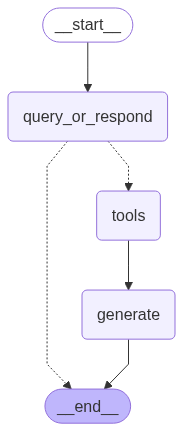

In [36]:
from langgraph.graph import StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.graph import START, END
from IPython.display import Image, display

builder = StateGraph(MessagesState)

builder.add_node('query_or_respond', query_or_respond)
# builder.add_node(query_or_respond)  # 이렇게 쓰는것도 가능함
builder.add_node('tools', tools)
builder.add_node('generate', generate)

# builder.set_entry_point('query_or_respond')
builder.add_edge(START, 'query_or_respond')
builder.add_conditional_edges(
    'query_or_respond',
    tools_condition,  # path - 조건에 따라 라우팅을 보냄 
    {END: END, 'tools': 'tools'}  # 정확하게 다음 노드를 지정할 수 있다. tools를 쓰지 않으면 END로, tools를 써야되면 tools로
)
builder.add_edge('tools', 'generate')
# builder.set_finish_point('generate')
builder.add_edge('generate', END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [37]:
input_state = {
    'messages': [
        {'role': 'user', 'content': '문서에서 에이전트에 대해 뭐라고 설명하고 있니?'}
    ]
}

res = graph.invoke(input_state)

for msg in res['messages']:
    msg.pretty_print()

================================ Human Message =================================

문서에서 에이전트에 대해 뭐라고 설명하고 있니?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_Lfc6cHqCgqo8ZEWspDdJHUKm)
 Call ID: call_Lfc6cHqCgqo8ZEWspDdJHUKm
  Args:
    query: 문서에서 에이전트에 대한 설명
================================= Tool Message =================================
Name: retrieve

('Source: {\'source\': \'https://lilianweng.github.io/posts/2023-06-23-agent/\'}\nContent: GPT-Engineer is another project to create a whole repository of code given a task specified in natural language. The GPT-Engineer is instructed to think over a list of smaller components to build and ask for user input to clarify questions as needed.\nHere are a sample conversation for task clarification sent to OpenAI ChatCompletion endpoint used by GPT-Engineer. The user inputs are wrapped in {{user input text}}.\n[\n  {\n    "role": "system",\n    "content": "You will read instructio

### 벡터스토어 대체(클라우드에)

In [34]:
# pinecone
import os 
from pinecone import Pinecone
from dotenv import load_dotenv

load_dotenv()

True

In [ ]:
# 이제 이 작업은 더이상 할 필요가 없어졌다
from langchain_community.document_loaders import WebBaseLoader
from bs4.filter import SoupStrainer
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_pinecone import PineconeVectorStore 

loader = WebBaseLoader(
    web_paths=('https://lilianweng.github.io/posts/2023-06-23-agent/',),
    bs_kwargs={
        'parse_only': SoupStrainer(class_=['post-content'])
    },
)
docs = loader.load()

splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=500
)
splitted_docs = splitter.split_documents(docs)

embedding = OpenAIEmbeddings(model='text-embedding-3-small')

pc = Pinecone()

index_name = 'gaida-1st'
# PineconeVectorStore.from_documents(
#     splitted_docs, 
#     index_name=index_name, 
#     embedding=embedding
# )  # 실행될 때마다 데이터가 들어가서 영구저장된다. 두번 실행하면 똑같은게 두번 들어감

In [ ]:
# 벡터스토어 불러오기 - 클라우드처럼 어디나에서 사용 가능. 대신 오래걸린다 -> 많이 쓰는 데이터를 캐싱해서 메모리에 올린다던가 해서 속도 개선 가능
vectorstore = PineconeVectorStore.from_existing_index(index_name=index_name, embedding=embedding)  # 기존 저장된 인덱스를 불러온다

In [38]:
input_state = {
    'messages': [
        {'role': 'user', 'content': '문서에서 에이전트에 대해 뭐라고 설명하고 있니?'}
    ]
}

res = graph.invoke(input_state)

for msg in res['messages']:
    msg.pretty_print()

================================ Human Message =================================

문서에서 에이전트에 대해 뭐라고 설명하고 있니?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_Y9qvCGwtnRtQJJXEN2ngD07w)
 Call ID: call_Y9qvCGwtnRtQJJXEN2ngD07w
  Args:
    query: 문서에서 에이전트에 대한 설명
================================= Tool Message =================================
Name: retrieve

('Source: {\'source\': \'https://lilianweng.github.io/posts/2023-06-23-agent/\'}\nContent: GPT-Engineer is another project to create a whole repository of code given a task specified in natural language. The GPT-Engineer is instructed to think over a list of smaller components to build and ask for user input to clarify questions as needed.\nHere are a sample conversation for task clarification sent to OpenAI ChatCompletion endpoint used by GPT-Engineer. The user inputs are wrapped in {{user input text}}.\n[\n  {\n    "role": "system",\n    "content": "You will read instructio

### 대화 기록 저장하기(Langgraph Memory)

In [39]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [43]:
config = {
    'configurable': {'thread_id': 'abc123'}
}

input_state = {
    'messages': [
        {'role': 'user', 'content': '문서에서는 뭐라고 했는데?'}
    ]
}

res = graph.invoke(input_state, config)

for msg in res['messages']:
    msg.pretty_print()

================================ Human Message =================================

안녕?
================================== Ai Message ==================================

안녕하세요! 무엇을 도와드릴까요? 😊
================================ Human Message =================================

task decomposition에 대해 설명해봐
================================== Ai Message ==================================

네, "task decomposition"에 대해 설명드리겠습니다.

**Task Decomposition(작업 분해)**란, 큰 작업이나 문제를 더 작고 관리하기 쉬운 하위 작업(subtasks)으로 나누는 과정을 말합니다. 이 방법은 복잡한 문제를 해결하거나 프로젝트를 효율적으로 관리할 때 매우 유용하게 사용됩니다.

### 주요 목적
- **복잡성 감소:** 큰 문제를 작은 단위로 나누면 각 부분을 더 쉽게 이해하고 처리할 수 있습니다.
- **효율성 향상:** 여러 사람이 동시에 하위 작업을 맡아 병렬적으로 진행할 수 있습니다.
- **진행 상황 추적:** 각 하위 작업의 완료 여부를 확인하면서 전체 진행 상황을 쉽게 파악할 수 있습니다.

### 예시
1. **소프트웨어 개발:**  
   "웹사이트 만들기"라는 큰 작업을  
   - 디자인
   - 프론트엔드 개발
   - 백엔드 개발
   - 테스트  
   등으로 나눌 수 있습니다.

2. **논문 작성:**  
   "논문 작성"이라는 작업을  
   - 자료 조사
   - 초안 작성
   - 수정 및 교정
   - 참고문헌 정리  
   등으로 분해할 수 있습니다.

### 적용 분야
- 프로젝트 관리
- 인공지능(특히, 